# 4 Pre-Processing and Training Data<a id='4_Pre-Processing_and_Training_Data'></a>

## 4.1 Contents<a id='4.1_Contents'></a>
* [4 Pre-Processing and Training Data](#4_Pre-Processing_and_Training_Data)
  * [4.1 Contents](#4.1_Contents)
  * [4.2 Introduction](#4.2_Introduction)
  * [4.3 Imports](#4.3_Imports)
  * [4.4 Load Data](#4.4_Load_Data)
    * [4.4.1 Map categorical features to numeric values](#4.4.1_Map_categorical_features_to_numeric_values)
  * [4.5 Feature Engineering with Count Vectorizer and Tfidf Vectorizer](#4.5_Feature_Engineering_with_Count_Vectorizer_and_Tfidf_Vectorizer)
  * [4.6 Train/Test Split](#4.6_Train/Test_Split)
  * [4.7 Initial Dummy Model](#4.7_Initial_Dummy_Model)
    * [4.7.1 Metrics](#4.7.1_Metrics)
      * [4.7.1.1 Precision, recall and f1-score](#4.7.1.1_Precision,_recall_and_f1-score)
      * [4.7.1.2 Confusion Matrix](#4.7.1.2_Confusion_Matrix)
      * [4.7.1.3 ROC-AUC score](#4.7.1.3_ROC-_AUC_score)
  * [4.8 Multinomial Naive Bayes Model](#4.8_Multinominal_Naive_Bayes_Model)
    * [4.8.1 Make predictions on the train and test sets](#4.8.1_Make_predictions_on_the_train_and_test_sets)
    * [4.8.2 Assess performance](#4.8.2_Assess_performance)
  * [4.9 Logistic Regression Model](#4.9_Logistic_Regression_Model)
    * [4.9.1 Make predictions on the train and test sets](#4.9.1_Make_predictions_on_the_train_and_test_sets)
    * [4.9.2 Assess performance](#4.9.2_Assess_performance)
  * [4.10 Support Vector Classifier Model](#4.10_Support_Vector_Classifier_Model)
    * [4.10.1 Make predictions on the train and test sets](#4.10.1_Make_predictions_on_the_train_and_test_sets)
    * [4.10.2 Assess performance](#4.10.2_Assess_performance) 
  * [4.11 Random Forest Model](#4.11_Random_Forest_Model)
    * [4.11.1 Make predictions on the train and test sets](#4.11.1_Make_predictions_on_the_train_and_test_sets)
    * [4.11.2 Assess performance](#4.11.2_Assess_performance)                  
  * [4.12 Data quantity assessment](#4.12_Data_quantity_assessment)
  * [4.13 Save best model object from pipeline](#4.13_Save_best_model_object_from_pipeline)
  * [4.14 Summary](#4.14_Summary)

## 4.2 Introduction<a id='4.2_Introduction'></a>

## 4.3 Imports<a id='4.3_Imports'></a>

In [1]:
import pandas as pd
import numpy as np
from nltk.util import ngrams
import nltk.corpus
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.impute import SimpleImputer

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, precision_recall_curve
import time
from sklearn import __version__ as sklearn_version
from sklearn.pipeline import make_pipeline
import os, time
from sklearn.pipeline import Pipeline

## 4.4 Load the Data<a id='4.4_Load the Data'></a>

In [2]:
df = pd.read_csv('cleaned_data.csv',index_col=None)

In [3]:
df.describe()

,title,text,subject,date,label
count,44898,44267,44898,44898,44898
unique,38681,38637,8,2397,2
top,factbox trump fill top job administration,reuters highlights us president donald trum...,politicsnews,"December 20, 2017",FAKE
freq,14,8,11272,182,23481


### 4.4.1 Map categorical features to numeric values<a id='4.4.1_Map_categorical_features_to_numeric_values'></a>

In [4]:
df['label'] = df['label'].map({'FAKE':0, 'TRUE':1, np.nan: 2} )

In [5]:
df.isnull().sum()

title        0
text       631
subject      0
date         0
label        0
dtype: int64

### 4.4.2 Remove Missing Values<a id='4.4.1_Remove_missing_values'></a>

In [6]:
df = df.dropna()

## 4.5 Feature Engineering with Count Vectorizer and Tfidf Vectorizer<a id='4.5_Feature_Engineering_with_Count_Vectorizer_and_Tfidf_Vectorizer'></a>

In [7]:
df['allwords'] = df['title']+" "+df['text']+" "+df['subject']
df = df[['allwords','label']]

## 4.6 Train/Test Split<a id='4.6_Train/Test_Split'></a>

In [8]:
X = df['allwords']
y = df['label']

In [9]:
X_train, X_test, y_train,y_test= train_test_split(X, y, test_size=0.3,random_state=42,stratify=y)

In [10]:
columns = ['Model Name', 'accuracy','precision','recall','ROC AUC score','run time']
results = pd.DataFrame(columns=columns)

## 4.7 Models and Metrics<a id='4.7_Models_and_Metrics'></a>

### 4.7.1 Metrics<a id='4.7.1_Metrics'></a>

In classification task there are a number of things that we can look to understand how good a model is performing. Precision, recall, f1 score, and ROC-AUC score are typically used metrics for classification problems. `sklearn.metrics` provides many commonly used metrics, included the ones mentioned here.

In [11]:
 def metrics(model_name,y_test,y_pred):
    accuracy = accuracy_score(y_test,y_pred)
    roc_auc =roc_auc_score(y_test, y_pred)
    precision = precision_score(y_pred=y_pred, y_true=y_test,zero_division=1)
    recall = recall_score(y_pred=y_pred, y_true=y_test,zero_division=1)
    
    print(classification_report(y_test, y_pred,zero_division=1))

    cf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(cf_matrix, annot=True,fmt='3', cmap='Blues')
    plt.xlabel('Predicted user status',fontsize=12)
    plt.ylabel('True user status',fontsize=12)
    plt.title('%s Confusion Matrix' % model_name,fontsize=20)
    plt.show()

    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    plt.plot([0,1], [0,1], 'k--')
    plt.plot(fpr, tpr, label=model_name)
    plt.xlabel('False Positive Rate',fontsize=12)
    plt.ylabel('True Positive Rate',fontsize=12)
    plt.title('%s ROC Curve'% model_name,fontsize=20)
    plt.legend(fontsize=12)
    plt.show()
    #pipes = pipes.append(pipe)
    #return pd.DataFrame([[model_name,accuracy, precision, recall,roc_auc,t1]],columns=columns)

### 4.7.2 Dummy Model<a id='4.7.2_Dummy_Model'></a>

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__max_df': (0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 11.1min finished
C:\Users\Imran\anaconda3\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


done in 688.445s

Best score: 0.503
Best parameters set:
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      6856
           1       0.47      0.48      0.48      6425

    accuracy                           0.49     13281
   macro avg       0.49      0.49      0.49     13281
weighted avg       0.49      0.49      0.49     13281



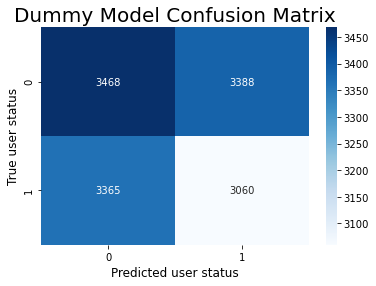

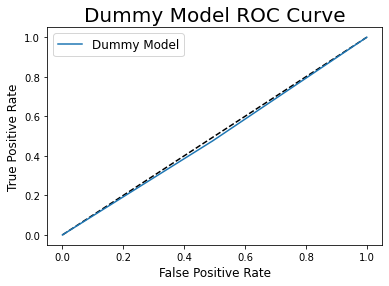

In [12]:
model_name = 'Dummy Model'
       
pipeline = Pipeline([
    ('vect', CountVectorizer(lowercase=False)),
    ('tfidf', TfidfTransformer()),
    ('clf', DummyClassifier()),
])

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time.time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time.time() - t0))
    print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name])) 

y_pred = grid_search.predict(X_test)
results = results.append(metrics(model_name,y_test,y_pred))

### 4.7.3 MultiNomial Naive Bayes<a id='4.7.3_MultiNomial_Naive_Bayes'></a>

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__max_df': (0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 11.1min finished


done in 751.277s

Best score: 0.966
Best parameters set:
	vect__max_df: 0.75
	vect__ngram_range: (1, 2)
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      6856
           1       0.96      0.97      0.97      6425

    accuracy                           0.97     13281
   macro avg       0.97      0.97      0.97     13281
weighted avg       0.97      0.97      0.97     13281



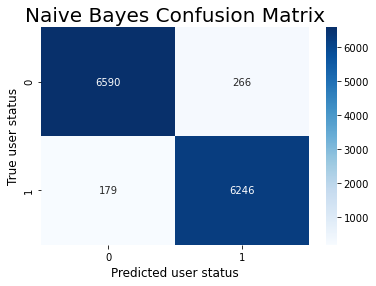

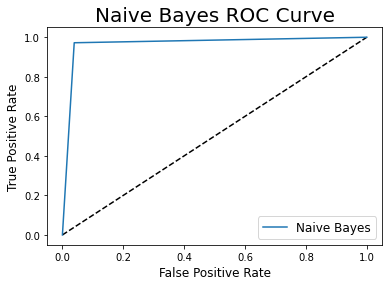

In [13]:
model_name = 'Naive Bayes'
       
pipeline = Pipeline([
    ('vect', CountVectorizer(lowercase=False)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    #'clf__onehot__threshold': (0.0, 1.0, 2.0, 3.0),
    #'clf__bayes__alpha': (0.0, 1.0),
    #'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 50, 80),
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time.time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time.time() - t0))
    print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name])) 

y_pred = grid_search.predict(X_test)
results = results.append(metrics(model_name,y_test,y_pred))

### 4.7.4 Logistic Regression<a id='4.7.4_Logistic_Regression'></a>

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__max_df': (0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'clf__max_iter': (20,), 'clf__penalty': ('l2', 'elasticnet')}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 24.7min finished
C:\Users\Imran\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


done in 1577.598s

Best score: 0.990
Best parameters set:
	clf__max_iter: 20
	clf__penalty: 'l2'
	vect__max_df: 0.75
	vect__ngram_range: (1, 1)
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6856
           1       0.99      0.99      0.99      6425

    accuracy                           0.99     13281
   macro avg       0.99      0.99      0.99     13281
weighted avg       0.99      0.99      0.99     13281



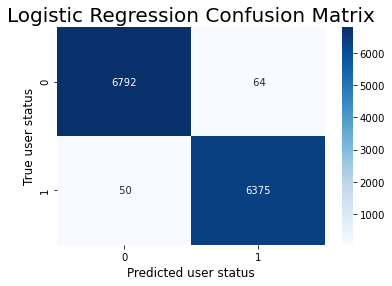

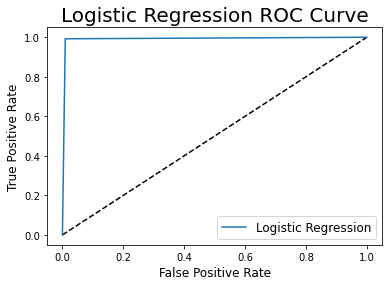

In [14]:
model_name = 'Logistic Regression'
       
pipeline = Pipeline([
    ('vect', CountVectorizer(lowercase=False)),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()),
])

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (20,),
    #'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 50, 80),
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time.time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time.time() - t0))
    print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name])) 

y_pred = grid_search.predict(X_test)
results = results.append(metrics(model_name,y_test,y_pred))

### 4.7.5 Stochastic Gradient Descent<a id='4.7.5_Stochastic_Gradient_Descent'></a>

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__max_df': (0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'clf__max_iter': (20,), 'clf__penalty': ('l2', 'elasticnet')}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 22.5min finished


done in 1374.249s

Best score: 0.995
Best parameters set:
	clf__max_iter: 20
	clf__penalty: 'l2'
	vect__max_df: 1.0
	vect__ngram_range: (1, 1)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6856
           1       1.00      1.00      1.00      6425

    accuracy                           1.00     13281
   macro avg       1.00      1.00      1.00     13281
weighted avg       1.00      1.00      1.00     13281



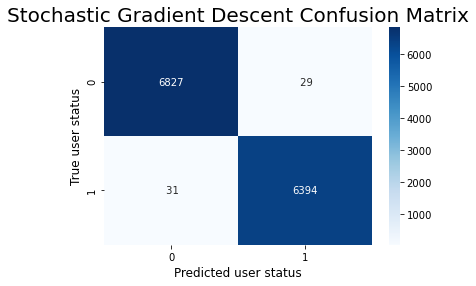

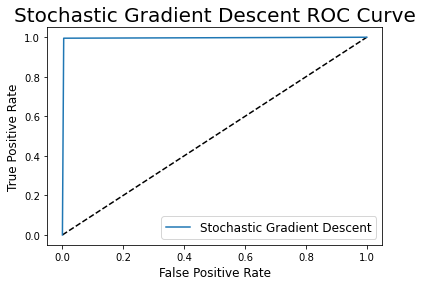

In [15]:
model_name = 'Stochastic Gradient Descent'
       
pipeline = Pipeline([
    ('vect', CountVectorizer(lowercase=False)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (20,),
    #'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 50, 80),
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time.time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time.time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name])) 

y_pred = grid_search.predict(X_test)
results = results.append(metrics(model_name,y_test,y_pred))

### 4.7.6 Random Forest Classifier<a id='4.7.6_Random_Forest_Classifier'></a>

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__max_df': (0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'clf__criterion': ('gini', 'entropy'), 'clf__max_features': ('auto', 'sqrt', 'log2')}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 119.0min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 465.1min finished


done in 28093.572s

Best score: 0.995
Best parameters set:
	clf__criterion: 'gini'
	clf__max_features: 'auto'
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6856
           1       1.00      0.99      0.99      6425

    accuracy                           0.99     13281
   macro avg       0.99      0.99      0.99     13281
weighted avg       0.99      0.99      0.99     13281



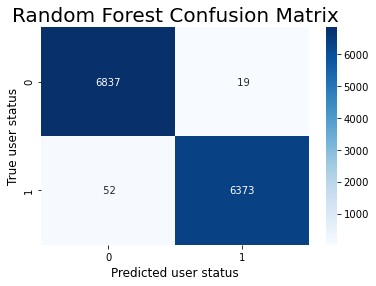

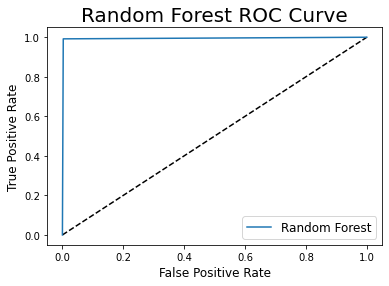

In [16]:
model_name = 'Random Forest'
       
pipeline = Pipeline([
    ('vect', CountVectorizer(lowercase=False)),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier()),
])

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    'clf__criterion': ('gini','entropy'),
    'clf__max_features': ('auto', 'sqrt', 'log2'),
    #'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 50, 80),
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time.time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time.time() - t0))
    print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name])) 

y_pred = grid_search.predict(X_test)
results = results.append(metrics(model_name,y_test,y_pred))

## 4.9 Data quantity assessment<a id='4.9_Data_quantity_assessment'></a>

In [46]:
fractions = [0.25, 0.35, 0.5, 0.75, 1.0]
train_size, train_scores, test_scores = learning_curve(grid_search.best_estimator_, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

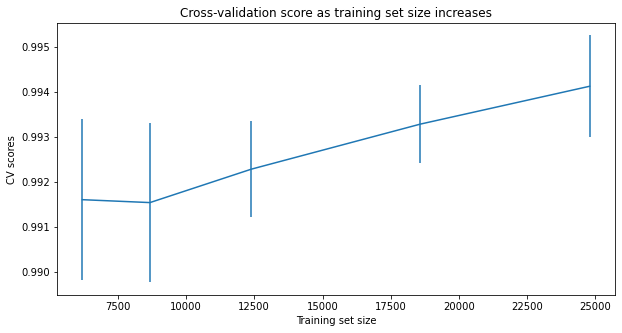

In [47]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

## 4.10 Save best model object from pipeline<a id='4.10_Save_best_model_object_from_pipeline'></a>

In [48]:
#import sklearn.externals.joblib as extjoblib
import joblib
import pickle

joblib.dump(grid_search.best_estimator_, 'best_model.pkl', compress = 1)

['best_model.pkl']

## 4.11 Summary<a id='4.11_Summary'></a>

From the 4 models it is observed that the exception of Naive Bayes all of them have very few mis-classification. The ROC_AUC score is close to 0.995 which is exceptionally well for text classification.  However, looking at the n-gram analysis it can be inferred that the data is biased towards US Presidential Election and any news outside this scope might be difficult for the model to predict. We need a bigger dataset covering a wide range of news for both TRUE and FAKE labels to make a more generalized model. 